In [8]:
import numpy as np
import sys
import string
import json

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [144]:
class TreeNode:
    def __init__(self):
        self.wordidx = -1
        self.label = -1
        self.idx = -1
        
    def parse(self, line, startIdx, word2idx):
        """
         Parses segment of the character array to a tree node. The parse starts from the specified
         index and returns the end index when the parsing completes.
         
         @param line the character array to parse
         @param startIdx start index of the array to parse
         @param word2idx 
         @return the end index of the array when completing the array
        """
        self.label = int(line[startIdx])
        
        self.children = []
        cword = []
        idx = startIdx + 1
        while idx < len(line):
            if line[idx] == '(':
                tn = TreeNode()
                self.children.append(tn)
                idx = tn.parse(line, idx + 1, word2idx) + 1
            elif line[idx] ==')':
                temp = ''.join(cword).strip()
                word = temp if len(temp) > 0 else None
                if word != None:
                    word = word.lower()
                    if word not in word2idx:
                        word2idx[word] = len(word2idx)
                    self.wordidx = word2idx[word]
                return idx
            else:
                cword.append(line[idx])
                idx += 1
        
        return -1
        

In [145]:
import queue
from queue import Queue

def bfs(root):
    
    queue = Queue()
    queue.put(root)
    curr_num = 1
    next_num = 0
    
    level_tracker = []
    while not queue.empty():
        t = queue.get()
        level_tracker.append(t)
        curr_num -= 1 
        num_children = len(t.children)
        if num_children > 0 :
            left = t.children[0]
            right = t.children[1]
            queue.put(left)
            queue.put(right)
            next_num+=2
        
        if curr_num == 0:
            curr_num = next_num
            next_num = 0
            for e in level_tracker:
                print(e.wordidx, e.label, e.idx, end='   ')
            print()
            level_tracker = []


In [146]:
input = "(4 (3 (2 A) (4 (4 (2 (2 deep) (2 and)) (3 meaningful)) (2 film))) (2 .))"

root = TreeNode()
word2idx = {}
root.parse(input, 1, word2idx)
bfs(root)
print(word2idx)

-1 4 -1   
-1 3 -1   5 2 -1   
0 2 -1   -1 4 -1   
-1 4 -1   4 2 -1   
-1 2 -1   3 3 -1   
1 2 -1   2 2 -1   
{'.': 5, 'film': 4, 'a': 0, 'and': 2, 'meaningful': 3, 'deep': 1}


In [147]:
def add_idx_to_tree(tree, current_idx):
    if tree is None:
        return current_idx
    
    num_children = len(tree.children)
    if num_children > 0 :
        current_idx = add_idx_to_tree(tree.children[0], current_idx)
        current_idx = add_idx_to_tree(tree.children[1], current_idx)
    
    tree.idx = current_idx
    current_idx+=1
    return current_idx


In [148]:
add_idx_to_tree(root, 0)
bfs(root)

-1 4 10   
-1 3 8   5 2 9   
0 2 0   -1 4 7   
-1 4 5   4 2 6   
-1 2 3   3 3 4   
1 2 1   2 2 2   


In [149]:
def tree2list(tree, parent_idx, is_binary=False, is_left=False, is_right=False):
    if tree is None:
        return [], [], [], []
    
    w = tree.wordidx
    if is_left:
        r = 0
    elif is_right:
        r = 1
    else:
        r = -1
     
    num_children = len(tree.children)
    if num_children > 0 :
        left = tree.children[0]
        right = tree.children[1] 
    else:
        left = None
        right = None
        
    words_left, parents_left, relations_left, labels_left = tree2list(left, tree.idx, is_binary, is_left=True)
    words_right, parents_right, relations_right, labels_right = tree2list(right, tree.idx, is_binary, is_right=True)
        
    words = words_left + words_right + [w]
    parents = parents_left + parents_right + [parent_idx]
    relations = relations_left + relations_right + [r]
    if is_binary:
        if tree.label > 2:
            label = 1
        elif tree.label < 2:
            label = 0
        else:
            label = -1
    else:
        label = tree.label
    labels = labels_left + labels_right + [label]
    
    return words, parents, relations, labels

In [150]:
wordidx, parents, relations, labels = tree2list(root, -1, is_binary=True)
print(wordidx)
print(parents)
print(relations)
print(labels)


[0, 1, 2, -1, 3, -1, 4, -1, -1, 5, -1]
[8, 3, 3, 5, 5, 7, 7, 8, 10, 10, -1]
[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -1]
[-1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1]


In [151]:
def save_data(data=None, data_file=None):
    if data == None or data_file == None:
        return
    with open(data_file, 'w') as f:
        json.dump(data, f)

**Test Saving Data**

In [152]:
#test

input1 = "(4 (4 (2 Enormously) (3 (4 entertaining) (4 (2 for) (3 (2 moviegoers) (2 (2 of) (3 (2 any) (2 age))))))) (2 .))"
input2 = "(4 (3 (2 A) (4 (4 (2 (2 deep) (2 and)) (3 meaningful)) (2 film))) (2 .))"

word2idx = {}
train = []
t1 = TreeNode();
t1.parse(input1, 1, word2idx)
train.append(t1)

t2 = TreeNode();
t2.parse(input2, 1, word2idx)
train.append(t2)

for t in train:
    add_idx_to_tree(t, 0)
    
train_b = {idx : tree2list(t, -1, is_binary=True) for t, idx in zip(train, range(len(train)))}
train = {idx : tree2list(t, -1, is_binary=False) for t, idx in zip(train, range(len(train)))}

print(word2idx)
print(train_b)
print(train)

save_data(word2idx, "sentiment_word2idx.json")
save_data(train_b, "sentiment_binary_train.json")
save_data(train, "sentiment_train.json")
# print(train[0])
print("Saved")

{'a': 8, 'moviegoers': 3, 'entertaining': 1, 'meaningful': 11, '.': 7, 'of': 4, 'any': 5, 'film': 12, 'age': 6, 'enormously': 0, 'and': 10, 'for': 2, 'deep': 9}
{0: ([0, 1, 2, 3, 4, 5, 6, -1, -1, -1, -1, -1, -1, 7, -1], [12, 11, 10, 9, 8, 7, 7, 8, 9, 10, 11, 12, 14, 14, -1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, -1], [-1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1]), 1: ([8, 9, 10, -1, 11, -1, 12, -1, -1, 7, -1], [8, 3, 3, 5, 5, 7, 7, 8, 10, 10, -1], [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -1], [-1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1])}
{0: ([0, 1, 2, 3, 4, 5, 6, -1, -1, -1, -1, -1, -1, 7, -1], [12, 11, 10, 9, 8, 7, 7, 8, 9, 10, 11, 12, 14, 14, -1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, -1], [2, 4, 2, 2, 2, 2, 2, 3, 2, 3, 4, 3, 4, 2, 4]), 1: ([8, 9, 10, -1, 11, -1, 12, -1, -1, 7, -1], [8, 3, 3, 5, 5, 7, 7, 8, 10, 10, -1], [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, -1], [2, 2, 2, 2, 3, 4, 2, 4, 3, 2, 4])}
Saved


In [153]:
word2idx = {}
train = []
test = []
folder_read = '../data/large_files/stanford_sentiment/trees/'
folder_write = '../data/large_files/stanford_sentiment/parsed_data/'

for line in open(folder_read + 'train.txt'):
    line = line.rstrip()
    if line:
        t = TreeNode();
        t.parse(line, 1, word2idx)
        train.append(t)

for line in open(folder_read + 'test.txt'):
    line = line.rstrip()
    if line:
        t = TreeNode();
        t.parse(line, 1, word2idx)
        test.append(t)

for t in train:
    add_idx_to_tree(t, 0)
train_b = {idx : tree2list(t, -1, is_binary=True) for t, idx in zip(train, range(len(train)))}
train = {idx : tree2list(t, -1, is_binary=False) for t, idx in zip(train, range(len(train)))}

for t in test:
    add_idx_to_tree(t, 0)
test_b = {idx : tree2list(t, -1, is_binary=True) for t, idx in zip(test, range(len(test)))}
test = {idx : tree2list(t, -1, is_binary=False) for t, idx in zip(test, range(len(test)))}

print(len(train_b))
print(len(test_b))

# print(len(word2idx)
print("finished")

8544
2210
finished


### Save data for recursive NN

In [142]:
print("Start Saving Data RNTN ...")
save_data(word2idx, folder_write + "sentiment_word2idx.json")
save_data(train_b, folder_write + "sentiment_binary_train.json")
save_data(train, folder_write + "sentiment_train.json")
save_data(test_b, folder_write + "sentiment_binary_test.json")
save_data(test, folder_write + "sentiment_test.json")
print("Data Saving Finished")

Start Saving Data RNTN ...
Data Saving Finished


****

## Load Data

In [20]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [21]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

****

## Preprocessing Data for RNN

### Exclude neutral samples

* The loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
* We exclude samples with neutral sentiment.

In [22]:
def exclude_neutral_sample(samples:dict):
    ssamples = {}
    for k, v in samples.items():
        if v[3][-1] != -1:
            ssamples[k] = v
    return ssamples
        
train_b = exclude_neutral_sample(sentiment_binary_train)
test_b = exclude_neutral_sample(sentiment_binary_test)

print("After filtering: # of training samples and # of test samples")
print("# of traing samples: ", len(train_b))
print("# of test samples: ", len(test_b))

After filtering: # of training samples and # of test samples
# of traing samples:  6920
# of test samples:  1821


### Convert comment in form of integers to string

In [23]:
# convert review comment in form of integers to the form of words
def get_comment(wordidx, idx2word:dict):
    wordlist = []
    for idx in wordidx:
        if idx != -1:
            token = idx2word[idx]
            # remove punctuation
            if token not in string.punctuation:
                wordlist.append(token)
    return wordlist

In [24]:
def get_comments_samples(samples:dict, idx2word:dict):
    comments = []
    targets = []
    for _, v in samples.items():
        if v[3][-1] != -1:
            # concatenate word list to a string
            comment = " ".join(get_comment(v[0], idx2word))
            label = v[3][-1]
            comments.append(comment)
            targets.append(label) 
    return comments, targets

** Create traing and testing samples in form of string **

In [41]:
idx2word = {v:k for k, v in word2idx.items()}
train_comments_o, train_targets = get_comments_samples(train_b, idx2word)
test_comments_o, test_targets = get_comments_samples(test_b, idx2word)

In [42]:
count0 = 0
count1 = 0
count2 = 0
for i in range(len(train_comments_o)):

    if train_targets[i] == 0:
        count0 += 1
    elif train_targets[i] == 1:
        count1 += 1
    else:
        count2 += 1
#     print(i, comments[i], targets[i])
    
print("# of training samples with label 0:", count0)
print("# of training samples with label 1:", count1)
print("# of training samples with label -1:", count2)

# of training samples with label 0: 3310
# of training samples with label 1: 3610
# of training samples with label -1: 0


In [43]:
vocabulary_size = len(idx2word)
print('vocabulary_size:' , vocabulary_size)

vocabulary_size: 18647


### Define preprocessing data function

In [31]:
def remove_punctuation(samples):
    filtered_samples = []
    for i in samples:
        filtered_samples.append(i.translate(str.maketrans('', '', string.punctuation)))
    return filtered_samples

In [32]:
# test
remove_punctuation(["Today's so beautiful!"])

['Todays so beautiful']

In [33]:
def tokenize(samples):
    tokenized_samples = []
    for s in samples:
        tokens = word_tokenize(s)
        tokenized_samples.append(tokens)
    return tokenized_samples

In [34]:
# test
tokenize(['Todays so beautiful'])

[['Todays', 'so', 'beautiful']]

In [35]:
stopWords = set(stopwords.words('english'))
print(stopWords)

{'whom', "you've", 'such', "weren't", 'both', 'at', "couldn't", 'just', 'did', "you'll", 'hasn', 'to', 'can', 'weren', 'be', 'an', "you'd", 'that', 'being', 'himself', 'through', 'why', "needn't", 'nor', "mightn't", "won't", 'was', "isn't", 'it', "mustn't", 'we', 'their', 'with', "it's", 'your', 'where', 'wasn', 've', 'm', 'up', 'should', 'about', 'out', 'them', 'so', 'is', 'ourselves', 'its', 'were', 'how', 's', 'does', 'here', 'needn', 'only', 'when', 'me', 'had', 'on', 'itself', 'aren', 'than', 'over', 'until', 'under', 'yours', 'during', 'of', 'couldn', "wasn't", 'down', "shouldn't", 'which', "wouldn't", 'do', 'most', 'mustn', 'myself', 'her', 'y', 'this', 'our', 'i', 'she', 'his', 'further', "hasn't", 'if', 'above', 'shouldn', 'am', "aren't", 'for', 'hadn', 'shan', "don't", 'will', 'by', 're', "hadn't", 'from', 'are', 'as', 'after', 'him', 'ma', 'all', 'll', 'herself', "you're", 'having', 'hers', 'before', 'off', "shan't", 'isn', 'same', 'too', 'into', 'don', 'themselves', 'doing'

**Stopwords not include negation word**

In [36]:
stopWords_revised = set(('at', 'how', 'each', 's', 'those', 'from','whom', 'if', 're', 'we', 'by','into', 'it', 'ma', 'than', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
             'which', 'now', 'ours', 'in', "you've", 'before', 'further', 'below', 'did',  'who', 'once', 'some', 'being', 
             'does', 'too', 'herself', 'about', 'my', 'are', 'during', 'few', 'an', 'do', 'over',  'themselves', 'the', 'why', 'a', 'same', 'all', 
             'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', 'that', 'am', 'through', 'll', 'so', 've', "you're", 'doing', 'between', 
             'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', 'they', 'theirs', 'm', 'both', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 'more', 
                'd', 'o', 'what', 'having', 't', 'this', 'after', 'no', 'then', 'above', 'out', "should've", 'his', 
               "you'd", "she's", 'and', 'shan', 'until', 'here', 'for', 'just', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


**Stopwords not include negation word and other words**

"beyond", "over", "very"

In [37]:
stopWords_revised_2 = set(('at', 'each', 's', 'those', 'from', 'if', 're', 'we', 'by','into', 'it', 'ma', "you'll", 
              'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
              'now', 'ours', 'in', "you've", 'below', 'did', 'being', 
             'does', 'herself', 'about', 'my', 'are', 'an', 'do', 'themselves', 'the',  'a',  
             'own', 'myself', 'he',  'himself', 'these', 'that', 'am', 'll', 'so', 've', "you're", 'doing', 
            'ourselves', 'been', 'of', 'our', 'them', 'their', 'can', 'yourself', 'they', 'theirs', 'm', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 
                'd', 'o', 'having', 't', 'this', 'after', 'then', 'out', "should've", 'his', 
               "you'd", "she's", 'shan',  'here', 'for', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [38]:
def remove_stopwords(samples):
    filtered_samples = []
    for s in samples:
        filstered_tokens = []
        for w in s:
            if w not in stopWords_revised_2:
                filstered_tokens.append(w)
        filtered_samples.append(filstered_tokens)
    return filtered_samples  

In [39]:
# test
remove_stopwords([['Todays', 'so', 'not', 'beautiful']])

[['Todays', 'not', 'beautiful']]

###  Preprocessing data

* Remove punctation
* Remove stopwords

**Orginal Data**

In [82]:
for i in range(10):
    print(i, ": ", train_comments_o[i])

0 :  watching this gentle mesmerizing portrait of a man coming to terms with time you barely realize your mind is being blown
1 :  the film is enriched by an imaginatively mixed cast of antic spirits headed by christopher plummer as the subtlest and most complexly evil uncle ralph i 've ever seen in the many film and stage adaptations of the work
2 :  the town has kind of an authentic feel but each one of these people stand out and everybody else is in the background and it just seems manufactured to me and artificial
3 :  apparently designed as a reverie about memory and regret but the only thing you 'll regret is remembering the experience of sitting through it
4 :  the film sounds like the stuff of lurid melodrama but what makes it interesting as a character study is the fact that the story is told from paul 's perspective
5 :  humorless self-conscious art drivel made without a glimmer of intelligence or invention
6 :  ... a solid well-formed satire
7 :  as quiet patient and tenacio

**Perserve n't**

In [45]:
train_comments_1 = []
for comment in train_comments_o:
    new_str = comment.replace("n't", 'not')
    train_comments_1.append(new_str)
    
test_comments_1 = []
for comment in test_comments_o:
    new_str = comment.replace("n't", 'not')
    test_comments_1.append(new_str)

In [80]:
for i in range(10):
    print(i, ": ", train_comments_1[i])

0 :  watching this gentle mesmerizing portrait of a man coming to terms with time you barely realize your mind is being blown
1 :  the film is enriched by an imaginatively mixed cast of antic spirits headed by christopher plummer as the subtlest and most complexly evil uncle ralph i 've ever seen in the many film and stage adaptations of the work
2 :  the town has kind of an authentic feel but each one of these people stand out and everybody else is in the background and it just seems manufactured to me and artificial
3 :  apparently designed as a reverie about memory and regret but the only thing you 'll regret is remembering the experience of sitting through it
4 :  the film sounds like the stuff of lurid melodrama but what makes it interesting as a character study is the fact that the story is told from paul 's perspective
5 :  humorless self-conscious art drivel made without a glimmer of intelligence or invention
6 :  ... a solid well-formed satire
7 :  as quiet patient and tenacio

**Remove punctuation**

In [47]:
train_comments_punc = remove_punctuation(train_comments_1)
test_comments_punc = remove_punctuation(test_comments_1)
print("punctuation removed")

punctuation removed


In [81]:
for i in range(10):
    print(i, ": ", train_comments_punc[i])

0 :  watching this gentle mesmerizing portrait of a man coming to terms with time you barely realize your mind is being blown
1 :  the film is enriched by an imaginatively mixed cast of antic spirits headed by christopher plummer as the subtlest and most complexly evil uncle ralph i ve ever seen in the many film and stage adaptations of the work
2 :  the town has kind of an authentic feel but each one of these people stand out and everybody else is in the background and it just seems manufactured to me and artificial
3 :  apparently designed as a reverie about memory and regret but the only thing you ll regret is remembering the experience of sitting through it
4 :  the film sounds like the stuff of lurid melodrama but what makes it interesting as a character study is the fact that the story is told from paul s perspective
5 :  humorless selfconscious art drivel made without a glimmer of intelligence or invention
6 :   a solid wellformed satire
7 :  as quiet patient and tenacious as mr

** Tokenize **

In [49]:
train_comments_tokenized = tokenize(train_comments_punc)
test_comments_tokenized = tokenize(test_comments_punc)
print("tokenized")

tokenized


In [78]:
for i in range(20):
    print(i, ": ", train_comments_tokenized[i])

0 :  ['watching', 'this', 'gentle', 'mesmerizing', 'portrait', 'of', 'a', 'man', 'coming', 'to', 'terms', 'with', 'time', 'you', 'barely', 'realize', 'your', 'mind', 'is', 'being', 'blown']
1 :  ['the', 'film', 'is', 'enriched', 'by', 'an', 'imaginatively', 'mixed', 'cast', 'of', 'antic', 'spirits', 'headed', 'by', 'christopher', 'plummer', 'as', 'the', 'subtlest', 'and', 'most', 'complexly', 'evil', 'uncle', 'ralph', 'i', 've', 'ever', 'seen', 'in', 'the', 'many', 'film', 'and', 'stage', 'adaptations', 'of', 'the', 'work']
2 :  ['the', 'town', 'has', 'kind', 'of', 'an', 'authentic', 'feel', 'but', 'each', 'one', 'of', 'these', 'people', 'stand', 'out', 'and', 'everybody', 'else', 'is', 'in', 'the', 'background', 'and', 'it', 'just', 'seems', 'manufactured', 'to', 'me', 'and', 'artificial']
3 :  ['apparently', 'designed', 'as', 'a', 'reverie', 'about', 'memory', 'and', 'regret', 'but', 'the', 'only', 'thing', 'you', 'll', 'regret', 'is', 'remembering', 'the', 'experience', 'of', 'sitti

**Remove stopwords**

In [51]:
train_comments_stopwords = remove_stopwords(train_comments_tokenized)
test_comments_stopwords = remove_stopwords(test_comments_tokenized)
print("stopwords removed")

stopwords removed


In [83]:
for i in range(10):
    print(i, ": ", train_comments_stopwords[i])

0 :  ['watching', 'gentle', 'mesmerizing', 'portrait', 'man', 'coming', 'terms', 'with', 'time', 'barely', 'realize', 'mind', 'blown']
1 :  ['film', 'enriched', 'imaginatively', 'mixed', 'cast', 'antic', 'spirits', 'headed', 'christopher', 'plummer', 'as', 'subtlest', 'and', 'most', 'complexly', 'evil', 'uncle', 'ralph', 'ever', 'seen', 'many', 'film', 'and', 'stage', 'adaptations', 'work']
2 :  ['town', 'kind', 'authentic', 'feel', 'but', 'one', 'people', 'stand', 'and', 'everybody', 'else', 'background', 'and', 'just', 'seems', 'manufactured', 'and', 'artificial']
3 :  ['apparently', 'designed', 'as', 'reverie', 'memory', 'and', 'regret', 'but', 'only', 'thing', 'regret', 'remembering', 'experience', 'sitting', 'through']
4 :  ['film', 'sounds', 'like', 'stuff', 'lurid', 'melodrama', 'but', 'what', 'makes', 'interesting', 'as', 'character', 'study', 'fact', 'story', 'told', 'paul', 'perspective']
5 :  ['humorless', 'selfconscious', 'art', 'drivel', 'made', 'without', 'glimmer', 'inte

** Create word-to-index and index-to-word maps **

In [84]:
def combine(tokenized_comments):
    text = []
    for comment in tokenized_comments:
        text += comment
    return text

all_words = combine(train_comments_stopwords) + combine(test_comments_stopwords)

In [86]:
print(len(all_words))
print(all_words[:100])

99167
['watching', 'gentle', 'mesmerizing', 'portrait', 'man', 'coming', 'terms', 'with', 'time', 'barely', 'realize', 'mind', 'blown', 'film', 'enriched', 'imaginatively', 'mixed', 'cast', 'antic', 'spirits', 'headed', 'christopher', 'plummer', 'as', 'subtlest', 'and', 'most', 'complexly', 'evil', 'uncle', 'ralph', 'ever', 'seen', 'many', 'film', 'and', 'stage', 'adaptations', 'work', 'town', 'kind', 'authentic', 'feel', 'but', 'one', 'people', 'stand', 'and', 'everybody', 'else', 'background', 'and', 'just', 'seems', 'manufactured', 'and', 'artificial', 'apparently', 'designed', 'as', 'reverie', 'memory', 'and', 'regret', 'but', 'only', 'thing', 'regret', 'remembering', 'experience', 'sitting', 'through', 'film', 'sounds', 'like', 'stuff', 'lurid', 'melodrama', 'but', 'what', 'makes', 'interesting', 'as', 'character', 'study', 'fact', 'story', 'told', 'paul', 'perspective', 'humorless', 'selfconscious', 'art', 'drivel', 'made', 'without', 'glimmer', 'intelligence', 'invention', 'soli

In [54]:
# Create your dictionary that maps vocab words to integers here
from collections import Counter
counts = Counter(all_words)
print(type(counts))

vocab = sorted(counts, key=counts.get, reverse=True)

# Note that index start from 1
vocab_to_int = {word:i for i, word in enumerate(vocab, 1)}

<class 'collections.Counter'>


In [55]:
print("type of vocab", type(vocab))
print('total # of words: ', len(vocab_to_int))
print("first word:", vocab[0])
print("last word:", vocab[-1])
print("first word index:", vocab_to_int[vocab[0]])
print("last word index", vocab_to_int[vocab[-1]])

type of vocab <class 'list'>
total # of words:  16548
first word: and
last word: bombards
first word index: 1
last word index 16548


In [56]:
# create index to word map
index2word = {idx:word for word, idx in vocab_to_int.items()}

** Convert the review to integer **

Convert the reviews to integers, same shape as reviews list, but in form of integers

In [57]:
def convert_to_int(reviews, vocab_to_int):
    # Convert the reviews to integers, same shape as reviews list, but in form of integers
    print('# of reviews before index: ', len(reviews))
    reviews_ints = []
    for review in reviews:
        reviews_ints.append([vocab_to_int[word] for word in review])

    print('# of reviews after index: ', len(reviews_ints))
    return reviews_ints

In [58]:
x_train = convert_to_int(train_comments_stopwords, vocab_to_int)

# of reviews before index:  6920
# of reviews after index:  6920


In [64]:
# test
print('original review:\n', train_comments_o[7])
print('processed review in integers:\n', x_train[7])
text = [index2word[idx] for idx in x_train[7]]
print('processed review in words\n', text)

original review:
 as quiet patient and tenacious as mr. lopez himself who approaches his difficult endless work with remarkable serenity and discipline
processed review in integers:
 [2, 585, 2917, 1, 10866, 2, 203, 2310, 17, 5712, 587, 1822, 43, 4, 454, 7888, 1, 7450]
processed review in words
 ['as', 'quiet', 'patient', 'and', 'tenacious', 'as', 'mr', 'lopez', 'who', 'approaches', 'difficult', 'endless', 'work', 'with', 'remarkable', 'serenity', 'and', 'discipline']


In [65]:
x_test = convert_to_int(test_comments_stopwords, vocab_to_int)

# of reviews before index:  1821
# of reviews after index:  1821


** Analyze review length **

In [71]:
from collections import Counter

# Create length to frequency map
x_train_lens_map = Counter([len(x) for x in x_train])
x_train_lens = [len(x) for x in x_train]
print("train - Zero-length reviews: {}".format(x_train_lens_map[0]))
print("train - Maximum train example length: {}".format(max(x_train_lens_map)))

x_test_lens_map = Counter([len(x) for x in x_test])
x_test_lens = [len(x) for x in x_test]
print("test - Zero-length reviews: {}".format(x_test_lens_map[0]))
print("test - Maximum test example length: {}".format(max(x_test_lens_map)))

train - Zero-length reviews: 2
train - Maximum train example length: 36
test - Zero-length reviews: 0
test - Maximum test example length: 31


In [76]:
ave_len = 0
for i in x_train:
    ave_len += len(i) 
ave_len = ave_len / len(x_train)
print("averge length for training samples:", ave_len)

ave_len = 0
for i in x_test:
#     print(i)
    ave_len += len(i)  
ave_len = ave_len / len(x_test)
print("averge length for testing samples:", ave_len)

averge length for training samples: 11.346387283236995
averge length for testing samples: 11.339923119165293


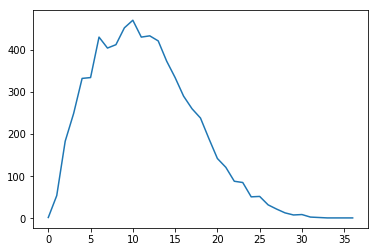

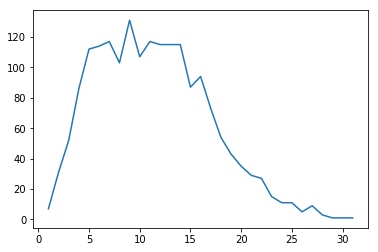

In [77]:
import matplotlib.pyplot as plt
plt.plot(list(x_train_lens_map.keys()), list(x_train_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

plt.plot(list(x_test_lens_map.keys()), list(x_test_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

###  Padding

* left padding
* right padding

In [95]:
def left_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # left padding
        features[i, -len(row):] = np.array(row)[:seq_len]
        
        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [96]:
def right_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # right padding
        features[i, :len(row)] = np.array(row)[:seq_len]

        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [97]:
## test

sample1 = [4,6,7,2,3,5,7,8,1]
sample2 = [1,2,3,4,6,7,2,3,5,7]
sample3 = [1,2,3,4,6,7,2,3,26,1, 11, 12]
sample4 = [8,7,3]
samples = []
samples.append(sample1)
samples.append(sample2)
samples.append(sample3)
samples.append(sample4)
features_, lengths_ = left_padding(samples, 10)

print(features_)
print(lengths_)

[[ 0  4  6  7  2  3  5  7  8  1]
 [ 1  2  3  4  6  7  2  3  5  7]
 [ 1  2  3  4  6  7  2  3 26  1]
 [ 0  0  0  0  0  0  0  8  7  3]]
[9, 10, 10, 3]


** Filter out samples with zero length **

In [90]:
x_train_f = []
y_train_f = []
for idx in range(len(x_train)):
    if len(x_train[idx]) != 0:
        x_train_f.append(x_train[idx])
        y_train_f.append(train_targets[idx])

x_test_f = []
y_test_f = []
for idx in range(len(x_test)):
    if len(x_test[idx]) != 0:
        x_test_f.append(x_test[idx])
        y_test_f.append(test_targets[idx])

** Left/right padding **

In [98]:
seq_len = 36
x_train_p, x_train_len = left_padding(x_train_f, seq_len)
x_test_p, x_test_len = left_padding(x_test_f, seq_len)

In [99]:
print(x_train_p[:5,:seq_len])
print(x_train_len[:5])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0   117
    533  1125   293   128   690   885     4    27   501  1489   296  4753]
 [    0     0     0     0     0     0     0     0     0     0     5  8189
   5983  1404    78  9929  1976  5091  3023  4449     2  7744     1    18
  10413   826  7438  4033    82   134    64     5     1  1384  3930    43]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0  2883    97  1243    99     6     8
     66   904     1  3530   361  2282     1    19   107  2840     1  1939]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0  1164  1191     2
  14267   714     1  3266     6    32   102  3266  3590   187   949    53]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   

** Resplit training data **

In [101]:
print(x_train_p.shape)
print(x_test_p.shape)

(6918, 36)
(1821, 36)


In [102]:

x_train_ = np.append(x_train_p, x_test_p[:1086], axis=0)
x_test_ = x_test_p[1086:]

y_train_ = np.array(np.append(y_train_f, y_test_f[:1086], axis=0))
y_test_ = np.array(y_test_f[1086:])

x_train_len_ = np.append(x_train_len, x_test_len[:1086], axis=0)
x_test_len_ = x_test_len[1086:]

print(len(x_train_))
print(len(x_test_))
print(len(y_train_))
print(len(y_test_))
print(len(x_train_len_))
print(len(x_test_len_))

8004
735
8004
735
8004
735


In [104]:
print(x_train_.shape, type(x_train_))
print(x_test_.shape, type(x_test_))
print(y_train_.shape, type(y_train_))
print(y_test_.shape, type(y_test_))
# print(x_train_len_.shape)
# print(x_test_len_.shape)

(8004, 36) <class 'numpy.ndarray'>
(735, 36) <class 'numpy.ndarray'>
(8004,) <class 'numpy.ndarray'>
(735,) <class 'numpy.ndarray'>


****

## Using Naive Bayes and SVM 

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

all_comments = train_comments_0 + test_comments_0

print('# of train comments:', len(train_comments_0))
print('# of test comments:', len(test_comments_0))
print("total # of comments:", len(all_comments))
# Initialize a CoutVectorizer to use NLTK's tokenizer instead of its 
# default one (which ignores punctuation and stopwords). 
# Minimum document frequency set to 1. 
foovec = CountVectorizer(max_features=6000)
# sents turned into sparse vector of word frequency counts
# foovec = foovec.fit(all_comments)
foovec = foovec.fit(train_comments_0)
train_comments = foovec.transform(train_comments_0)
# test_comments = foovec.fit_transform(test_comments_0)

test_comments = foovec.transform(test_comments_0)

# foovec now contains vocab dictionary which maps unique words to indexes
# print(foovec.vocabulary_)
# print(foovec.stop_words_ )
# sents_counts has a dimension of 3 (document count) by 19 (# of unique words)
# print(sents_counts.shape)


# of train comments: 6920
# of test comments: 1821
total # of comments: 8741


In [89]:
print(train_comments.shape)
print(test_comments.shape)

(6920, 6000)
(1821, 6000)


In [90]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(train_comments)
# X_test = tfidf_transformer.fit_transform(test_comments)
X_test = tfidf_transformer.transform(test_comments)
# print(sents_tfidf.toarray()[0, 200:600])

print(X_train.shape[0])
print(X_test.shape[0])

6920
1821


In [91]:
print(train_comments.shape)
print(test_comments.shape)
print(X_train.shape)
print(X_test.shape)

(6920, 6000)
(1821, 6000)
(6920, 6000)
(1821, 6000)


In [92]:
# Now ready to build a classifier. 
# We will use Multinominal Naive Bayes as our model
from sklearn.naive_bayes import MultinomialNB

# Train a Multimoda Naive Bayes classifier
clf = MultinomialNB().fit(X_train, train_targets)

In [93]:
# Predicting the Test set results, find accuracy
from sklearn.metrics  import accuracy_score

print()
y_pred = clf.predict(X_test)
# print(y_pred.shape)
# print(test_targets.shape)


accuracy_score(test_targets, y_pred)

0.81164195496979685

In [94]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_targets, y_pred)
cm

array([[699, 213],
       [130, 779]])

In [95]:
from sklearn.svm import SVC
classifier_rbf = SVC(kernel='linear').fit(X_train, train_targets)
y_pred = classifier_rbf.predict(X_test)
accuracy_score(test_targets, y_pred)

0.80889621087314667

In [96]:
cm = confusion_matrix(test_targets, y_pred)
cm

array([[726, 186],
       [162, 747]])

In [101]:
from sklearn.model_selection import GridSearchCV
from time import time

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 453.360s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [102]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.77962427745664742

In [ ]:
def remove_punctuation(s):
    return s.translate(str.maketrans('','',string.punctuation))

sentence = "how ! are you --"
print(remove_punctuation(sentence))